<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 11th exercise: <font color="#C70039">Interpretable Machine Learning with LIME for Image Classification</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   03.01.2024
* Student: Max Hammer
* Immatriculation ID: 11153562

<img src="https://miro.medium.com/max/1400/1*K4HCitQxRrjcFekIsSZDSg.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
LIME stands for Local Interpretable Model-agnostic Explanations and was developed by Ribeiro et.al. in 2016 (https://arxiv.org/abs/1602.04938).

In this notebook LIME is going to be used to generate explanations for an image classification task. 
The basic idea applying LIME is to understand why a deep neural network predicts that an instance (image) belongs to a certain class (labrador in this case). 
This notebook is based on previous work by Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. test your own images to obtain explanations for your classification tasks.
5. change some hyperparameters
6. describe your observations and the LIME performance
---------------------------------

### Imports
Import all necessary python utilities for manipulation of images, plotting and numerical analysis.

In [43]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from   tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from   sklearn.linear_model import LinearRegression
import warnings

np.random.seed(666)

### InceptionV3 initialization
We are going to use the pre-trained InceptionV3 model available in Keras.

In [44]:
warnings.filterwarnings('ignore') 
inceptionV3_model = tensorflow.keras.applications.inception_v3.InceptionV3() #Load pretrained model

### Read and pre-process image
The instance to be explained (image) is resized and pre-processed to be suitable for Inception V3. This image is saved in the variable `Xi`. 

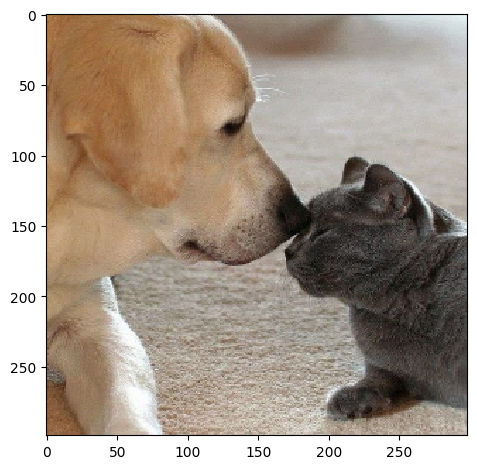

In [45]:
Xi = skimage.io.imread("./data/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

### Predict the class of the input image
The Inception V3 model is used to predict the class of the image. The output of the classification is a vector of 1000 proabilities of beloging to each class available in Inception V3. The description of these classes is shown and it can be seen that the "Labrador Retriever" is the top class for the given image.

In [46]:
np.random.seed(666)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

1/1 [==============================] - 0s 485ms/step


[('n02099712', 'Labrador_retriever', 0.8182905),
 ('n02099601', 'golden_retriever', 0.015929936),
 ('n02093428', 'American_Staffordshire_terrier', 0.010066416),
 ('n02108422', 'bull_mastiff', 0.00928703),
 ('n02109047', 'Great_Dane', 0.008600943)]

The indexes (positions) of the top 5 classes are saved in the variable `top_pred_classes`

In [47]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([208, 207, 180, 243, 246])

## LIME explanations
The following figure illustrates the basic idea behind LIME. The figure shows light and dark gray areas which are the decision boundaries for the classes for each (x1,x2) pairs in the dataset. LIME is able to provide explanations for the predictions of an individual record (blue dot). The  explanations are created by generating a new dataset of perturbations around the instance to be explained (colored markers around the blue dot). The output or class of each generated perturbation is predicted with the machine-learning model (colored markers inside and outside the decision boundaries). The importance of each perturbation is determined by measuring its distance from the original instance to be explained. These distances are converted to weights by mapping the distances to a zero-one scale using a kernel function (see color scale for the weights). All this information: the new generated dataset, its class predictions and its weights are used to fit a simpler model, such as a linear model (blue line), that can be interpreted. The attributes of the simpler model, coefficients for the case of a linear model, are then used to generate explanations.  
<img src="./images/lime_illustration.png" alt="LIME" width="600"/>

A detailed explanation of each step is shown below.

### Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. It can be noted that for the given image, 69 superpixels were generated. The generated superpixels are shown in the image below.

In [48]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

71

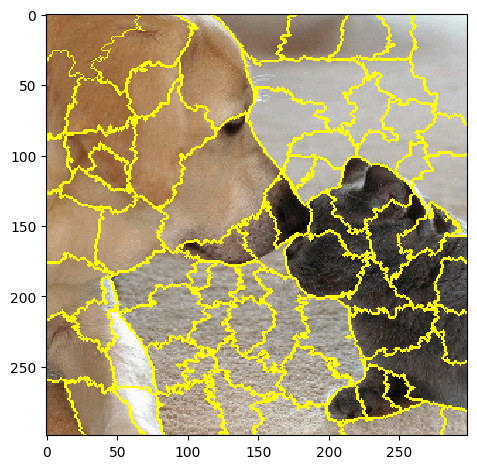

In [49]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

#### Create random perturbations
In this example, 150 perturbations were used. However, for real life applications, a larger number of perturbations will produce more reliable explanations. Random zeros and ones are generated and shaped as a matrix with perturbations as rows and superpixels as columns. An example of a perturbation (the first one) is show below. Here, `1` represents that a superpixel is on and `0` represents it is off. Notice that the length of the shown vector corresponds to the number of superpixels in the image.

In [50]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

In [51]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function to see what a perturbed image would look like:

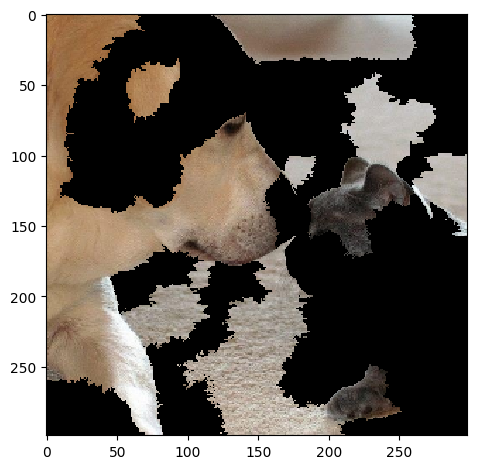

In [52]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

### Step 2: Use ML classifier to predict classes of new generated images
This is computationally the most expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions, we can see for each of the perturbations the output probability for each of the 1000 classes in Inception V3. 

In [53]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 44ms/step


(150, 1, 1000)

### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated pertubation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [54]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

#### Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

<img src="./images/kernel.png" alt="Drawing" width="600"/>

In [55]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is labrador, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [56]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.10800649,  0.07101281,  0.0143673 , -0.12473016, -0.03260856,
        0.0921349 , -0.0506914 , -0.06407556,  0.32258079,  0.06891138,
       -0.04992932,  0.02953827, -0.00239682, -0.02783269,  0.01592659,
       -0.01212004,  0.0633454 , -0.02240397,  0.04590526,  0.01564084,
       -0.09593606,  0.01098516,  0.09609363, -0.02705111,  0.14281607,
       -0.09277177,  0.35167668,  0.06959749, -0.05213867, -0.00969134,
       -0.06763007,  0.04328584,  0.0723966 ,  0.02656829, -0.05839629,
        0.0999546 , -0.05662074,  0.03270563,  0.0281608 , -0.04485573,
       -0.02374204,  0.0128269 ,  0.01203348, -0.0160019 , -0.05588728,
       -0.08407969, -0.10521257,  0.00442398,  0.01644687, -0.03097245,
       -0.01083118, -0.03736086, -0.03350771,  0.06830952,  0.08710257,
        0.04295002,  0.11155975,  0.0124333 ,  0.08406091, -0.01816685,
       -0.05840223,  0.04303025, -0.00706714,  0.07553488,  0.01072443,
       -0.05570392,  0.03840695,  0.00914061, -0.04500035,  0.02

#### Compute top features (superpixels)
Now, sort the coefficients to figure out which are the supperpixels, that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here the magnitude of the coefficients were used to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [57]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([56, 24,  8, 26])

#### Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

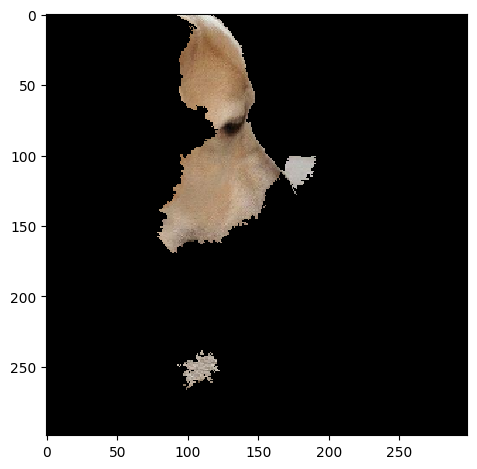

In [58]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

This is the final step where we obtain the area of the image that produced the prediction of labrador.

1/1 [==============================] - 0s 52ms/step
-------------- Top 5 Predictions -----------------
[('n03590841', "jack-o'-lantern", 0.9599397), ('n01877812', 'wallaby', 0.00042501866), ('n03961711', 'plate_rack', 0.0003396806), ('n03937543', 'pill_bottle', 0.00021179493), ('n02497673', 'Madagascar_cat', 0.00017562804)]


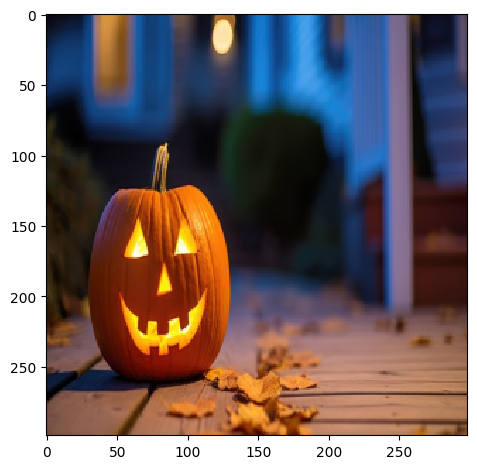

In [59]:
def preprocess_img(path):
    # Read and preprocess images
    Xi = skimage.io.imread(path)
    Xi = skimage.transform.resize(Xi, (299,299)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    return Xi

def predict_img(X):
    # Predict image
    np.random.seed(666)
    preds = inceptionV3_model.predict(X[np.newaxis,:,:,:])
    top_class_preds = decode_predictions(preds)[0] #Top 5 classes
    print('-------------- Top 5 Predictions -----------------')
    print(top_class_preds)
    return preds

lantern = preprocess_img("./data/jack-o-lantern.jpeg")

original_lantern_preds = predict_img(lantern)


1/1 [==============================] - 0s 59ms/step
-------------- Top 5 Predictions -----------------
[('n01871265', 'tusker', 0.73792744), ('n02504458', 'African_elephant', 0.2268973), ('n02504013', 'Indian_elephant', 0.01173608), ('n03075370', 'combination_lock', 0.00017841646), ('n02391049', 'zebra', 0.00017066639)]


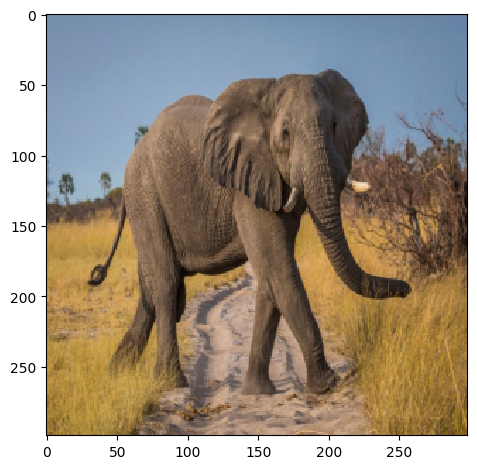

In [60]:
elephant = preprocess_img("./data/elephant.jpeg")

original_elephant_preds = predict_img(elephant)


Number of superpixels: 221


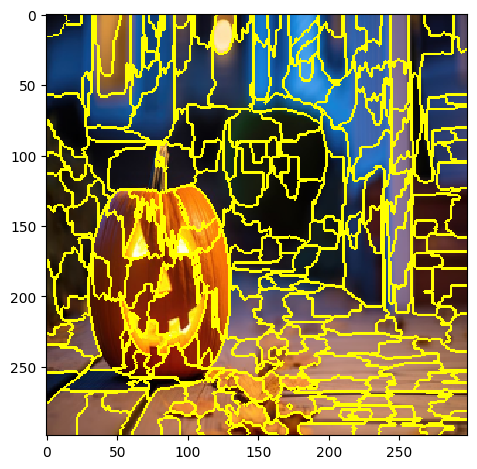

In [126]:
def add_superpixels(X):
    # Add superpixels 
    superpixels = skimage.segmentation.quickshift(X, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    print('Number of superpixels:', num_superpixels)
    skimage.io.imshow(skimage.segmentation.mark_boundaries(X/2+0.5, superpixels))
    return superpixels

lantern_superpixels = add_superpixels(lantern)

Number of superpixels: 263


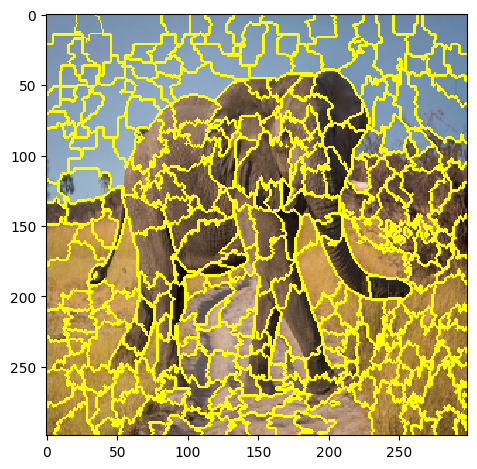

In [127]:
elephant_superpixels = add_superpixels(elephant)

In [128]:
def generate_perturbs(num_superpixels, num_perturb=150):
    # generate perturbations
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    return perturbations

lantern_perturbs = generate_perturbs(np.unique(lantern_superpixels).shape[0])
elephant_perturbs = generate_perturbs(np.unique(elephant_superpixels).shape[0])

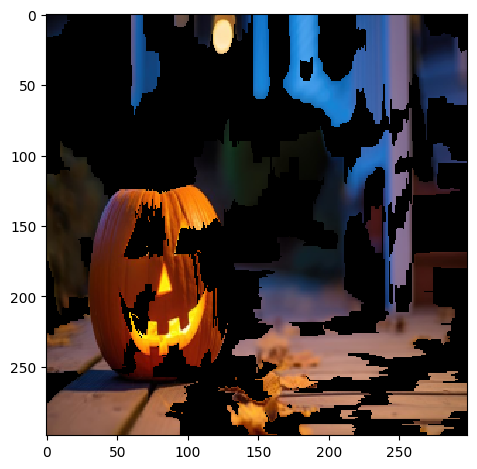

In [129]:
# Perturb images
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

skimage.io.imshow(perturb_image(lantern/2+0.5,lantern_perturbs[0],lantern_superpixels))

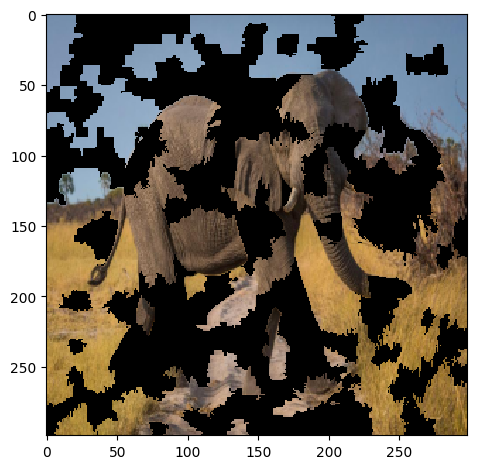

In [130]:
skimage.io.imshow(perturb_image(elephant/2+0.5,elephant_perturbs[0],elephant_superpixels))

In [131]:
# generate predictions for pertubations
def generate_predictions(X, perturbations, superpixels):
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(X,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    print(predictions.shape)
    return predictions

lantern_preds = generate_predictions(lantern, lantern_perturbs, lantern_superpixels)
elephant_preds = generate_predictions(elephant, elephant_perturbs, elephant_superpixels)

1/1 [==============================] - 0s 46ms/step
(150, 1, 1000)
1/1 [==============================] - 0s 44ms/step
(150, 1, 1000)


In [132]:
# Compute distance weights
def get_weights(original_image, num_superpixels, perturbations, kernel_width=.25):
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    return weights

lantern_weights = get_weights(lantern, np.unique(lantern_superpixels).shape[0], lantern_perturbs)
elephant_weights = get_weights(elephant, np.unique(elephant_superpixels).shape[0], elephant_perturbs)

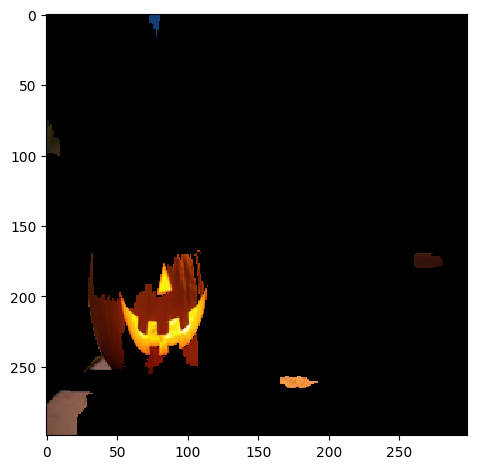

In [135]:
def get_lime_explanation(X, og_preds, predictions, perturbations, superpixels, weights, num_top_features=4):
    # Train simple model
    top_pred_classes = og_preds[0].argsort()[-5:][::-1]
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    top_features = np.argsort(coeff)[-num_top_features:] 

    num_superpixels = np.unique(superpixels).shape[0]
    # Show Lime explanation
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    skimage.io.imshow(perturb_image(X/2+0.5,mask,superpixels))

get_lime_explanation(lantern, original_lantern_preds, lantern_preds, lantern_perturbs, lantern_superpixels, lantern_weights, 5)


Top prediction: [('n01871265', 'tusker', 0.73792744), ('n02504458', 'African_elephant', 0.2268973), ('n02504013', 'Indian_elephant', 0.01173608), ('n03075370', 'combination_lock', 0.00017841646), ('n02391049', 'zebra', 0.00017066639)]
Top pertubation prediction: [('n02504458', 'African_elephant', 0.4649965), ('n03598930', 'jigsaw_puzzle', 0.31448537), ('n01871265', 'tusker', 0.068471566), ('n02504013', 'Indian_elephant', 0.029096544), ('n01855672', 'goose', 0.008643277)]


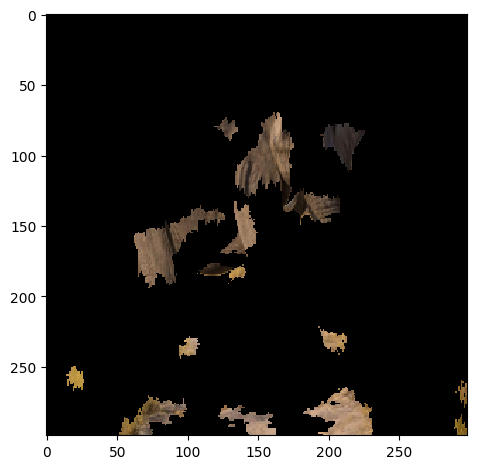

In [137]:
get_lime_explanation(elephant, original_elephant_preds, elephant_preds, elephant_perturbs, elephant_superpixels, elephant_weights,5)

print('Top prediction:',  decode_predictions(original_elephant_preds)[0])
print('Top pertubation prediction:',  decode_predictions(elephant_preds[0])[0])

Interestingly, the LIME explanation considers almost all parts of the animal besides the tuskers to be meaningful for its prediction, but the top prediction is "tusker" and not a breed of elephants.

The pertubated images most likely pertubate the tuskers in most cases and therefore lead the predictions to be "elephant" in most cases.
(I just tested this assumption by looking at a few samples of pertubated predictions.)

Changing the kernel_width seemed to have no impact when I changed its value from 0 - 1.